In [1]:
import sys
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#Data Preprocessing
import html
import re
#from wordcloud import WordCloud
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix


In [2]:
sentiment_dataset=pd.read_csv('training.1600000.processed.noemoticon.csv', delimiter=',', encoding='ISO-8859-1')
sentiment_dataset.head()

polarity of tweet   id of the tweet             date of the tweet  \
0                   0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
1                   0       1467810917  Mon Apr 06 22:19:53 PDT 2009   
2                   0       1467811184  Mon Apr 06 22:19:57 PDT 2009   
3                   0       1467811193  Mon Apr 06 22:19:57 PDT 2009   
4                   0       1467811372  Mon Apr 06 22:20:00 PDT 2009   

      query           user                                 text of the tweet   
0  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  
1  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...  
2  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire   
3  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....  
4  NO_QUERY       joy_wolf                      @Kwesidei not the whole crew

In [3]:
sentiment_dataset.columns = sentiment_dataset.columns.str.strip()
sentiment_dataset=sentiment_dataset[['text of the tweet']]
sentiment_dataset.columns=['tweet']
sentiment_dataset=sentiment_dataset.sample(20000)
sentiment_dataset=sentiment_dataset.reset_index(drop=True)

In [4]:
sentiment_dataset.head()

tweet
0  ouch I burnt my lip last week eating something...
1  @ThisisDavina Thankyou! We all miss it  .  And...
2  Plan today: hold it together...all day, then c...
3  We're gonna watch Family Outing later!! So exc...
4  @nekronurse your epic fail nights are better t...

In [5]:
tweet_category =  pd.read_json("News_Category_Dataset_v3.json", lines= True)
tweet_category.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

# data cleaning

In [6]:
#Function to remove empty row
def removeEmptyLine(df,col_name):
    df.replace("", pd.NA, inplace = True)
    df.dropna(subset=[col_name], inplace=True)
    return df

In [7]:
tweet_category = removeEmptyLine(tweet_category,"headline")
tweet_category = removeEmptyLine(tweet_category,"short_description")


In [8]:
# remove extra spaces
def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)

In [9]:
# remove contractions
contraction = {'cause':'because',
              'aint': 'am not',
              'aren\'t': 'are not'}

def mapping_replacer(x,dic):
    for words in dic.keys():
        if ' ' + words + ' ' in x:
            x=x.replace(' '+ words +' ' ,' '+dic[words]+' ' )
    return x

In [10]:
# stemming 
nltk.LancasterStemmer
ls = LancasterStemmer()
lem = WordNetLemmatizer()
def lexicon_normalization(text):
    words = word_tokenize(text) 
    
    
    # 1- Stemming
    words_stem = [ls.stem(w) for w in words]
    
    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem


In [11]:
def clean_text(text):
    if isinstance(text, str):
        # Make text lowercase
        text = text.lower()
        # Remove text in square brackets
        text = re.sub(r'\[.*?\]', '', text)
        # Remove links
        text = re.sub(r'http\S+', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove words containing numbers
        text = re.sub(r'\w*\d\w*', '', text)
        # Remove twitter handles
        text = re.sub('@[^\s]+', '', text)
        # Remove emojis
        text = text.encode('ascii', 'ignore').decode('ascii')
        # Remove hashtags
        text = re.sub(r'\B#\S+', '', text)
    
    return text

In [12]:
# Remove stop words
def remove_stopword(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

In [13]:
# tokenize the text
def tokenise(text):
    words = word_tokenize(text) 
    return words

In [14]:
sentiment_dataset['Text']=sentiment_dataset['tweet'].apply(lambda x:clean_text(x))
sentiment_dataset['Text'] = sentiment_dataset['Text'].map(lambda x: re.sub(r'\W+', ' ', str(x)))
sentiment_dataset['Text'] = sentiment_dataset['Text'].replace(r'\W+', ' ', regex=True)
sentiment_dataset['Text']=sentiment_dataset['Text'].apply(lambda x: mapping_replacer(x, contraction))
sentiment_dataset['Text']=sentiment_dataset['Text'].apply(lambda x: remove_stopword(x))
sentiment_dataset['Text']=sentiment_dataset['Text'].apply(lambda x: lexicon_normalization(x))

In [15]:
counts = tweet_category['category'].value_counts()
selected_categories = counts[counts > 4000].index.tolist()
tweet_category = tweet_category[['headline','category','short_description']][tweet_category['category'].isin(selected_categories)]


In [16]:
tweet_category=tweet_category.reset_index(drop=True)

In [17]:
tweet_category["summary"] = tweet_category["headline"] +' '+ tweet_category["short_description"]
tweet_category.head()

headline       category  \
0  23 Of The Funniest Tweets About Cats And Dogs ...         COMEDY   
1  The Funniest Tweets From Parents This Week (Se...      PARENTING   
2  Maury Wills, Base-Stealing Shortstop For Dodge...         SPORTS   
3  Golden Globes Returning To NBC In January Afte...  ENTERTAINMENT   
4  Biden Says U.S. Forces Would Defend Taiwan If ...       POLITICS   

                                   short_description  \
0  "Until you have a dog you don't understand wha...   
1  "Accidentally put grown-up toothpaste on my to...   
2  Maury Wills, who helped the Los Angeles Dodger...   
3  For the past 18 months, Hollywood has effectiv...   
4  President issues vow as tensions with China rise.   

                                             summary  
0  23 Of The Funniest Tweets About Cats And Dogs ...  
1  The Funniest Tweets From Parents This Week (Se...  
2  Maury Wills, Base-Stealing Shortstop For Dodge...  
3  Golden Globes Returning To NBC In January Afte...  
4  Biden Says U.S. Forces Would Defend Taiwan If ...

In [18]:
tweet_category['Text']=tweet_category['summary'].apply(lambda x:clean_text(x))
tweet_category['Text'] = tweet_category['Text'].map(lambda x: re.sub(r'\W+', ' ', str(x)))
tweet_category['Text'] = tweet_category['Text'].replace(r'\W+', ' ', regex=True)
tweet_category['Text']=tweet_category['Text'].apply(lambda x: mapping_replacer(x, contraction))
tweet_category['Text']=tweet_category['Text'].apply(lambda x: remove_stopword(x))
tweet_category['Text']=tweet_category['Text'].apply(lambda x: lexicon_normalization(x))

In [19]:
l=[]
for i in tweet_category['Text']:
    str1 = " " 
    t=str1.join(i)
    l.append(t)
tweet_category['Text']=l   

In [20]:
l=[]
for i in sentiment_dataset['Text']:
    str1 = " " 
    t=str1.join(i)
    l.append(t)
sentiment_dataset['Text']=l   

In [21]:
sia=SentimentIntensityAnalyzer()

dict_sent=sentiment_dataset["Text"].apply(lambda z:sia.polarity_scores((z)))
print(dict_sent)
positive=[]
negative=[]
neutral=[]
sentiment=[]
compound=[]
for w in dict_sent:
    positive.append(w['pos'])
    negative.append(w['neg'])
    neutral.append(w['neu'])
    compound.append(w["compound"])
    if (w['compound']>0.05):
        sentiment.append("positive")
    elif (w['compound']<-0.05):
        sentiment.append("negative")
    else:
        sentiment.append("neutral")

0        {'neg': 0.358, 'neu': 0.642, 'pos': 0.0, 'comp...
1        {'neg': 0.128, 'neu': 0.64, 'pos': 0.232, 'com...
2        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3        {'neg': 0.179, 'neu': 0.821, 'pos': 0.0, 'comp...
4        {'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'comp...
                               ...                        
19995    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
19996    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
19997    {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
19998    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
19999    {'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...
Name: Text, Length: 20000, dtype: object


In [22]:
sentiment_dataset['sentiment']=sentiment

# exploratory data analysis

# sentiment dataset

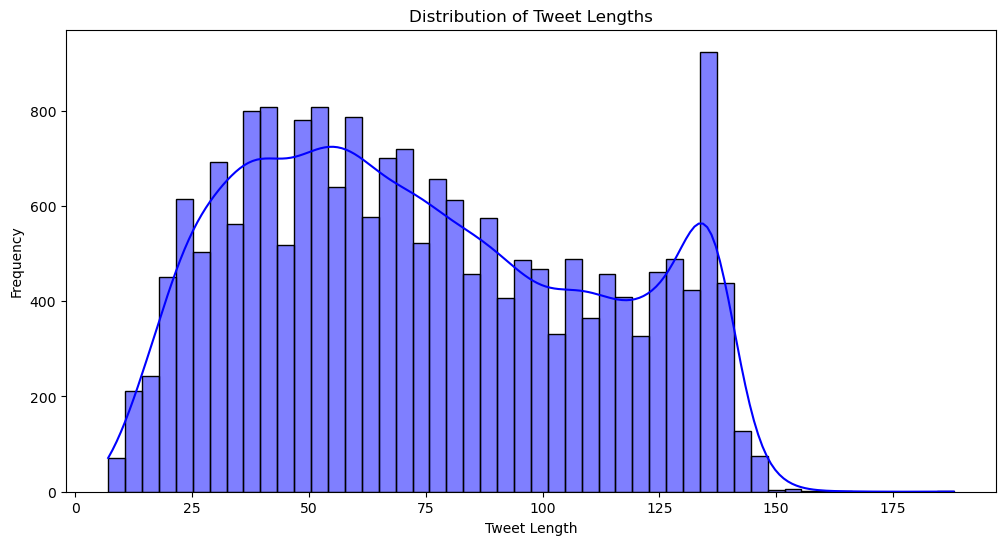

In [23]:
# Add a new column for tweet length
sentiment_dataset['tweet_length'] = sentiment_dataset['tweet'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(12, 6))
sns.histplot(sentiment_dataset['tweet_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

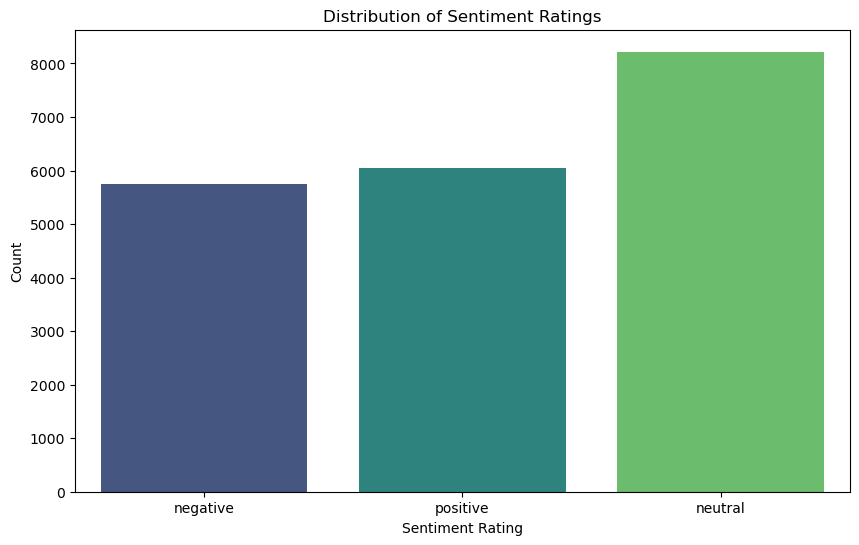

In [24]:

# Plot the distribution of sentiment ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=sentiment_dataset, palette='viridis')
plt.title('Distribution of Sentiment Ratings')
plt.xlabel('Sentiment Rating')
plt.ylabel('Count')
plt.show()



In [25]:
### Function to plot the wordcloud
def choose_category_content(df,category):
    articles_series = df[df['sentiment'] == category]['Text']
    words = ' '.join(articles_series)
    return words

def wordcloud_gen(df,category):  
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        min_font_size = 10).generate(choose_category_content(df,category))

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

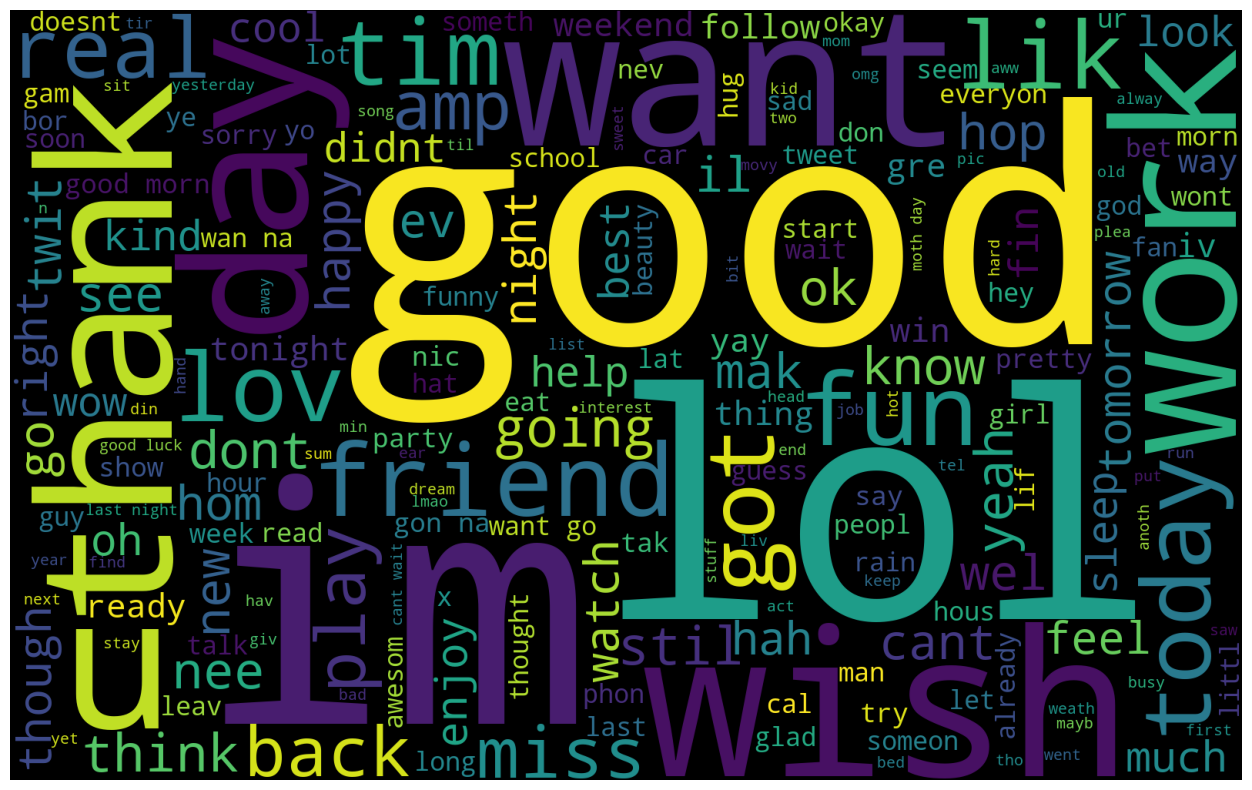

In [26]:
# word cloud for real
wordcloud_gen(sentiment_dataset,'positive')

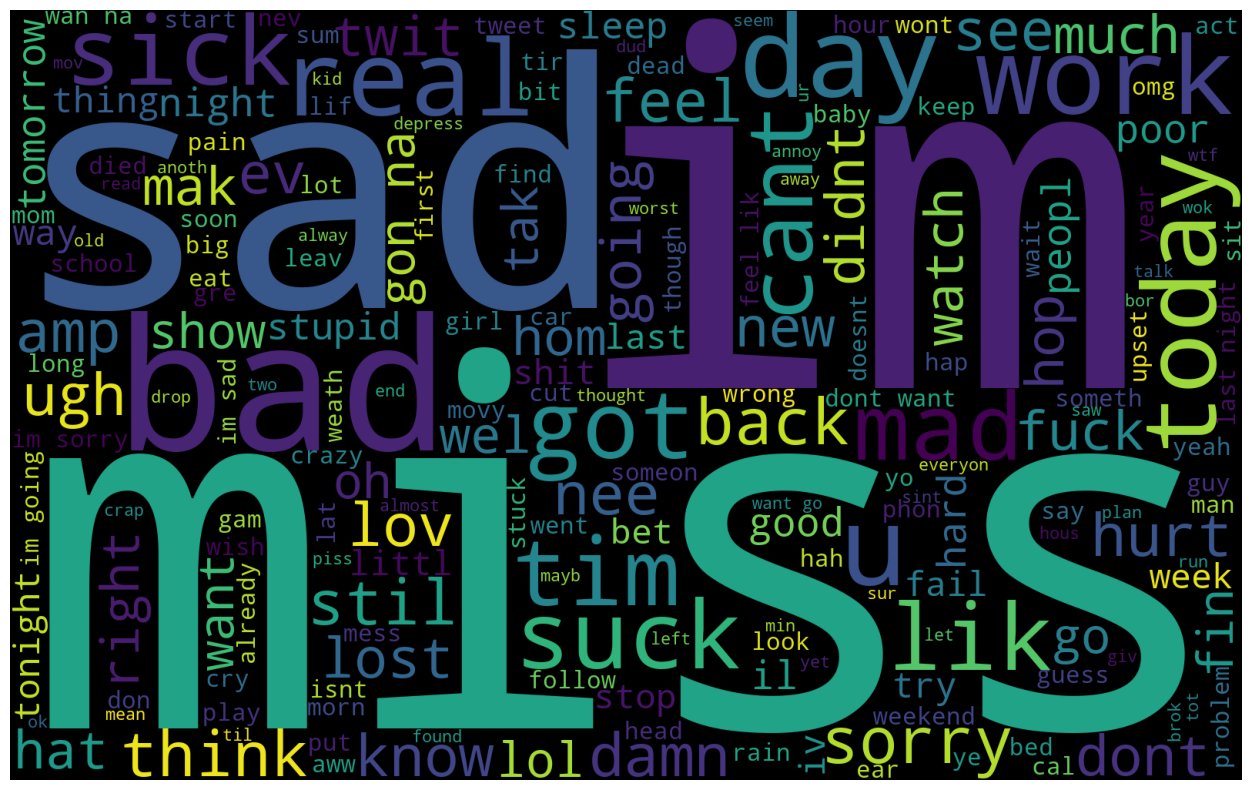

In [27]:
# word cloud for real
wordcloud_gen(sentiment_dataset,'negative')

# tweet category dataset

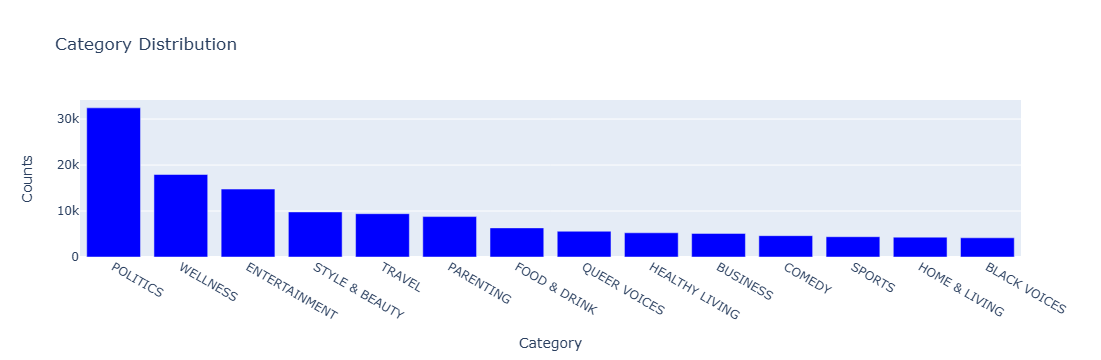

In [28]:
fig = px.bar(tweet_category['category'].value_counts(), x=tweet_category['category'].value_counts().index, y=tweet_category['category'].value_counts().values,
             labels={'x':'Category', 'y':'Counts'}, title='Category Distribution')
fig.update_traces(marker_color='blue')
fig.show()


In [29]:
### Function to plot the wordcloud
def choose_category_content(df,category):
    articles_series = df[df['category'] == category]['Text']
    words = ' '.join(articles_series)
    return words

def wordcloud_gen(df,category):  
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        min_font_size = 10).generate(choose_category_content(df,category))

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

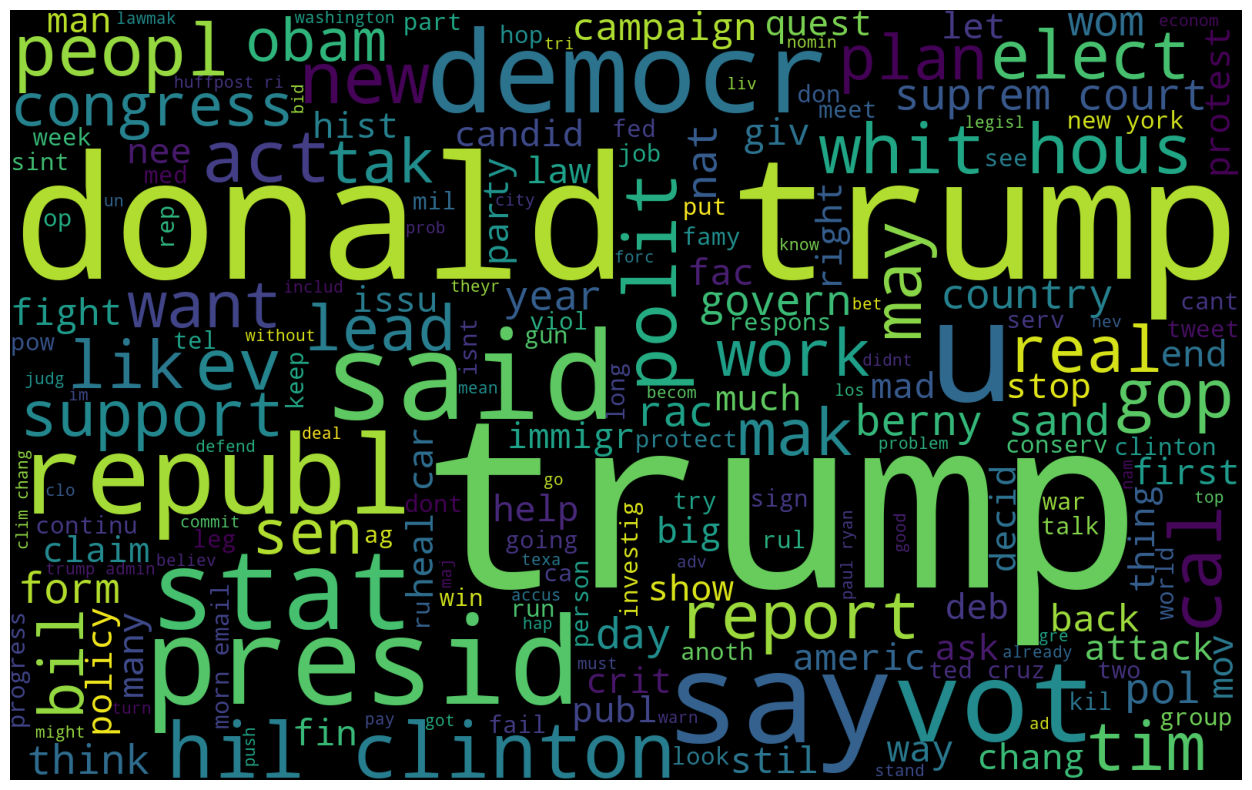

In [30]:
# word cloud for POLITICS
wordcloud_gen(tweet_category,'POLITICS')

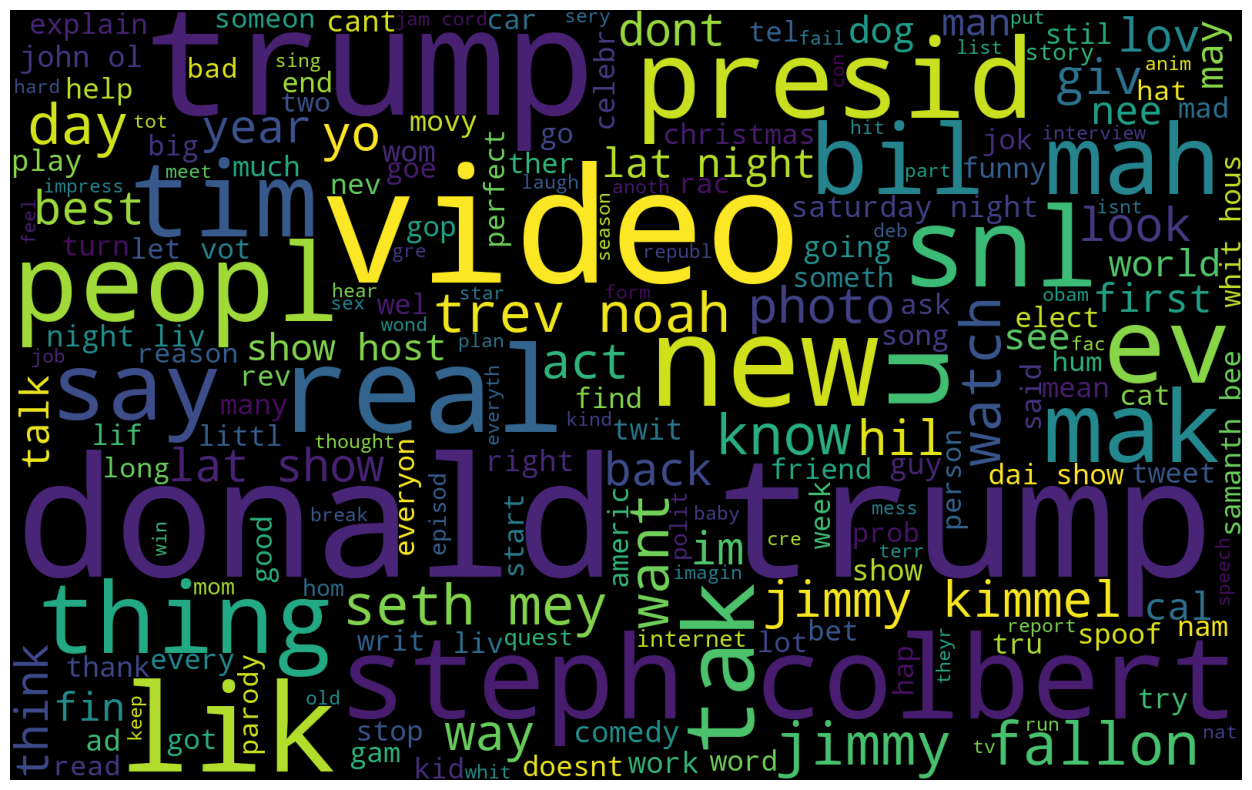

In [31]:
# word cloud for COMEDY
wordcloud_gen(tweet_category,'COMEDY')

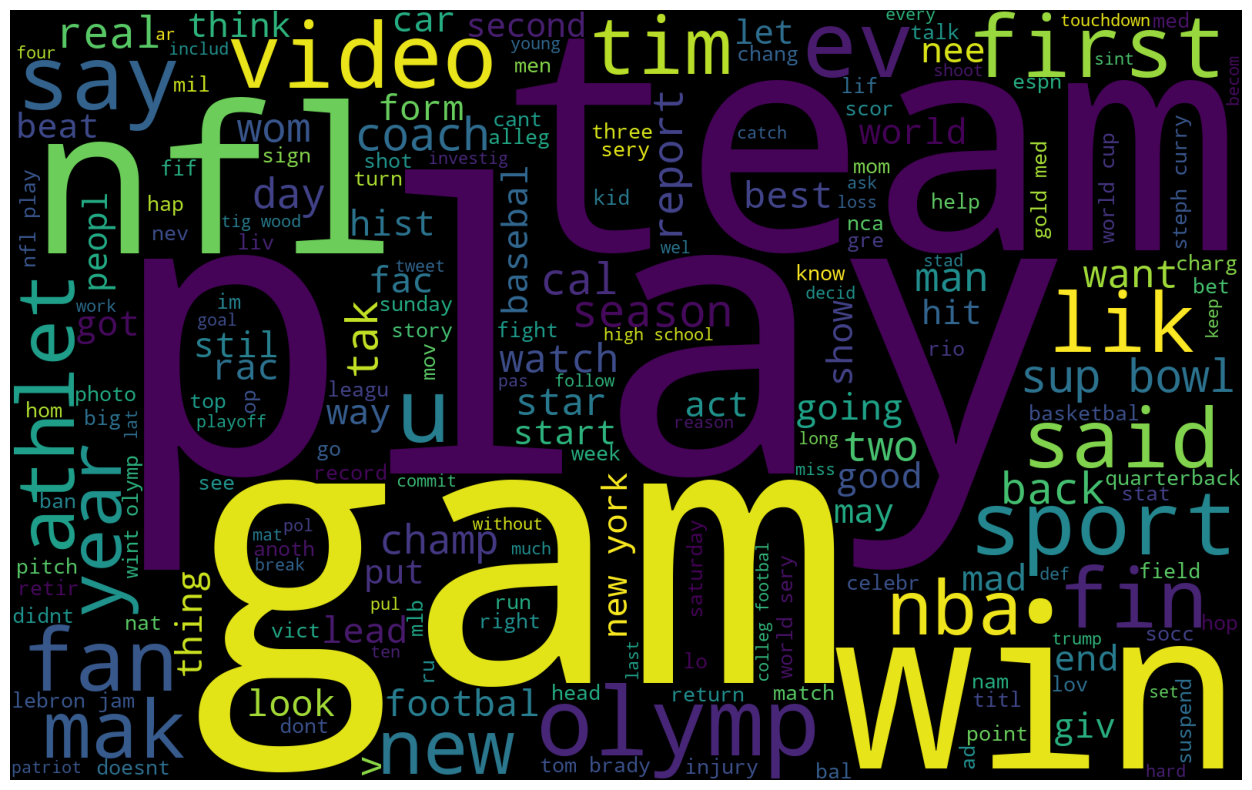

In [32]:
# word cloud for SPORTS
wordcloud_gen(tweet_category,'SPORTS')

# data preprocessing:sentiment dataset

In [33]:
 #Converting Tweet feature into a vector using TfidfVectorizer
vectorizer =  TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(sentiment_dataset['Text'])
b=vectorizer.get_feature_names_out()


In [34]:
 #creating a dataframe of the array which was converted into a vector and concatinating it with other features
df_final = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()) 

In [35]:
X=df_final.copy()
y=sentiment_dataset['sentiment']

In [36]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

# modeling: sentiment dataset

In [37]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [38]:
# Calculate accuracy score
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Generate classification report
report_lr = classification_report(y_test, y_pred_lr)
print(f'Accuracy on validation set{accuracy_lr}')
print('________________________________________')
print('Classification report')

print(report_lr)

Accuracy on validation set0.8622727272727273
________________________________________
Classification report
              precision    recall  f1-score   support

    negative       0.91      0.76      0.82      1893
     neutral       0.83      0.97      0.89      2702
    positive       0.89      0.82      0.85      2005

    accuracy                           0.86      6600
   macro avg       0.87      0.85      0.86      6600
weighted avg       0.87      0.86      0.86      6600



In [39]:
y.value_counts()

sentiment
neutral     8220
positive    6039
negative    5741
Name: count, dtype: int64

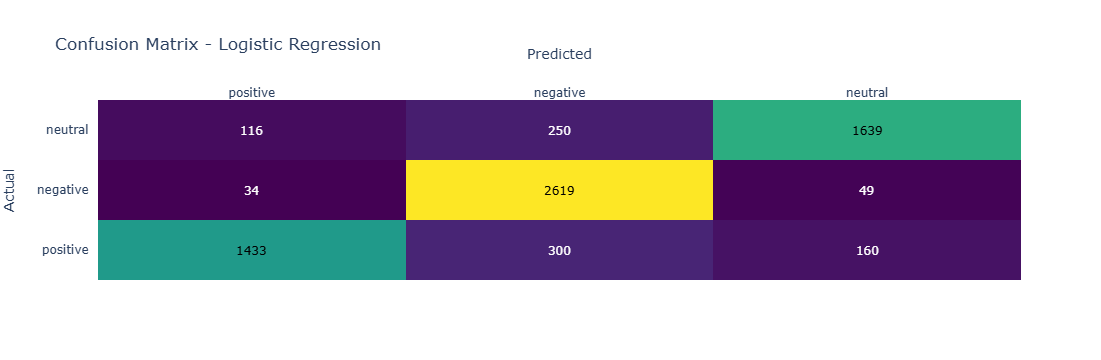

In [40]:

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Create a list of categories for the confusion matrix
categories = ['positive', 'negative', 'neutral']

# Create the confusion matrix plot
fig = ff.create_annotated_heatmap(conf_matrix_lr, x=categories, y=categories, colorscale='Viridis')

# Update the layout to add title and axis labels
fig.update_layout(title='Confusion Matrix - Logistic Regression',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')

fig.show()


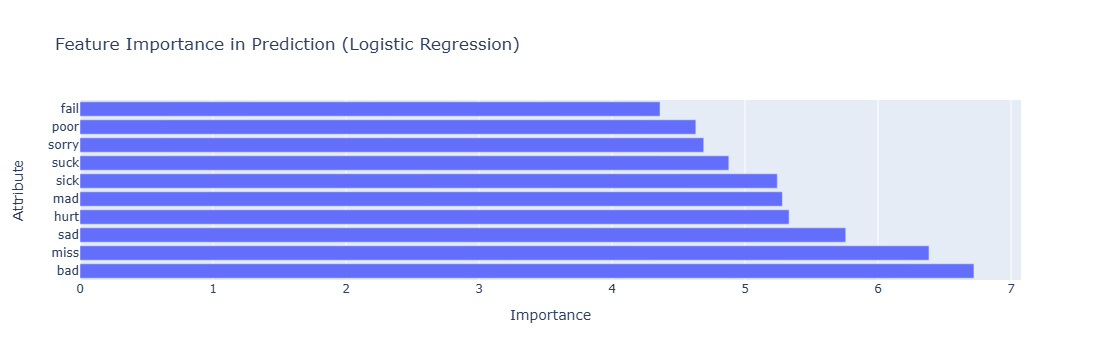

In [41]:

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

# Create a DataFrame from the top 10 features
top_features_lr = importances[:10]

# Create the bar chart
fig = px.bar(top_features_lr, x='Importance', y='Attribute', orientation='h', 
             title='Feature Importance in Prediction (Logistic Regression)',
             labels={'Importance':'Importance', 'Attribute':'Attribute'})

fig.show()


In [42]:
#Import the DTC from the Sklearn 
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=1000)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [43]:
# Calculate accuracy score
accuracy_dt = accuracy_score(y_test, y_pred)

# Generate classification report
accuracy_dt = classification_report(y_test, y_pred)
print(f'Accuracy on validation set{accuracy_lr}')
print('________________________________________')
print('Classification report')

print(report_lr)

Accuracy on validation set0.8622727272727273
________________________________________
Classification report
              precision    recall  f1-score   support

    negative       0.91      0.76      0.82      1893
     neutral       0.83      0.97      0.89      2702
    positive       0.89      0.82      0.85      2005

    accuracy                           0.86      6600
   macro avg       0.87      0.85      0.86      6600
weighted avg       0.87      0.86      0.86      6600



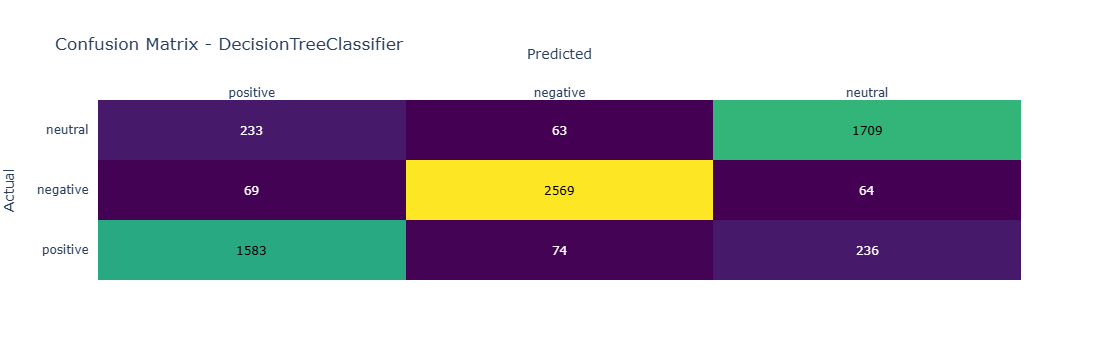

In [44]:

conf_matrix_dt = confusion_matrix(y_test, y_pred)

# Create a list of categories for the confusion matrix
categories = ['positive', 'negative', 'neutral']

# Create the confusion matrix plot
fig = ff.create_annotated_heatmap(conf_matrix_dt, x=categories, y=categories, colorscale='Viridis')

# Update the layout to add title and axis labels
fig.update_layout(title='Confusion Matrix - DecisionTreeClassifier',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')

fig.show()


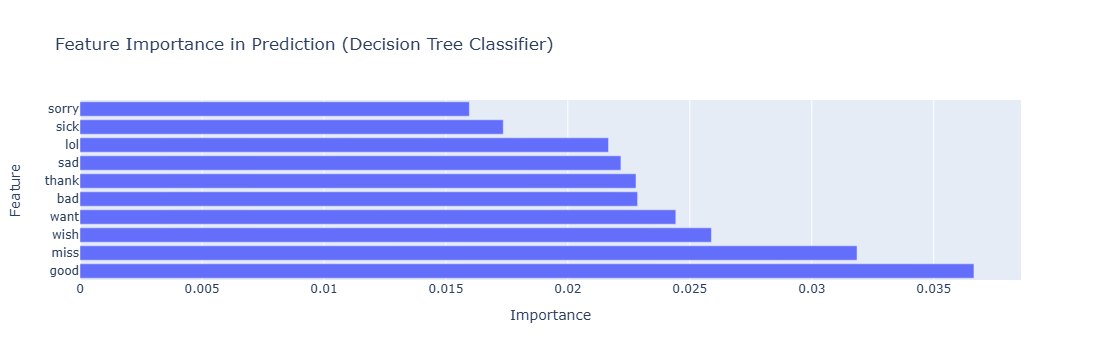

In [45]:

feature_scores = pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Create a DataFrame from the top 10 features
top_features = feature_scores[:10].reset_index()
top_features.columns = ['Feature', 'Importance']

# Create the bar chart
fig = px.bar(top_features, x='Importance', y='Feature', orientation='h', 
             title='Feature Importance in Prediction (Decision Tree Classifier)',
             labels={'Importance':'Importance', 'Feature':'Feature'})

fig.show()


In [46]:
#import the RFC from the Sklearn 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1000)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

In [47]:
# Calculate accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rfc)

# Generate classification report
report_lr = classification_report(y_test, y_pred_rfc)
print(f'Accuracy on validation set{accuracy_rf}')
print('________________________________________')
print('Classification report')

print(report_lr)

Accuracy on validation set0.9083333333333333
________________________________________
Classification report
              precision    recall  f1-score   support

    negative       0.89      0.85      0.87      1893
     neutral       0.93      0.97      0.95      2702
    positive       0.89      0.88      0.89      2005

    accuracy                           0.91      6600
   macro avg       0.90      0.90      0.90      6600
weighted avg       0.91      0.91      0.91      6600



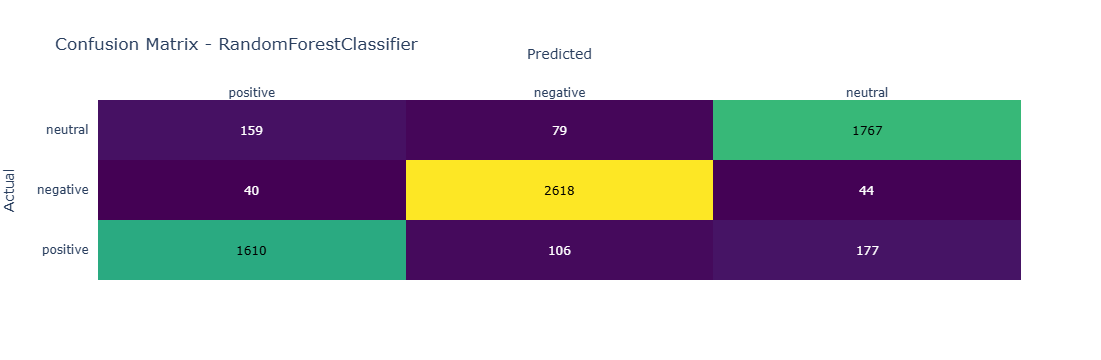

In [48]:

conf_matrix_rf= confusion_matrix(y_test, y_pred_rfc)

# Create a list of categories for the confusion matrix
categories = ['positive', 'negative', 'neutral']

# Create the confusion matrix plot
fig = ff.create_annotated_heatmap(conf_matrix_rf, x=categories, y=categories, colorscale='Viridis')

# Update the layout to add title and axis labels
fig.update_layout(title='Confusion Matrix - RandomForestClassifier',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')

fig.show()


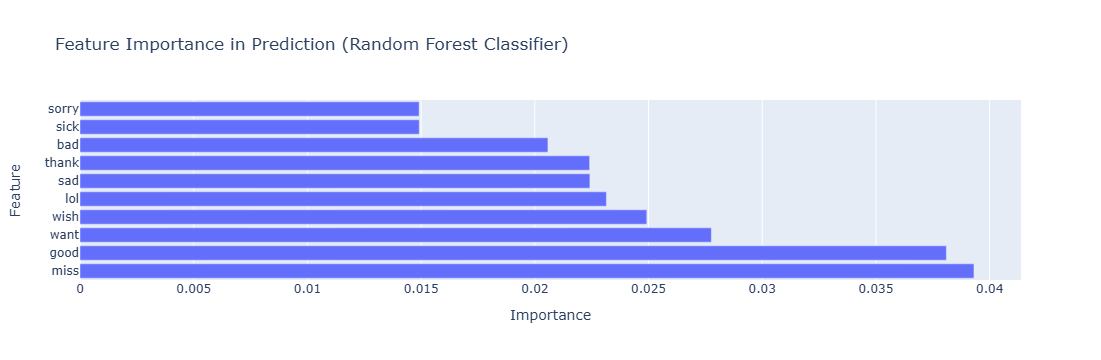

In [49]:

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Create a DataFrame from the top 10 features
top_features = feature_scores[:10].reset_index()
top_features.columns = ['Feature', 'Importance']

# Create the bar chart
fig = px.bar(top_features, x='Importance', y='Feature', orientation='h', 
             title='Feature Importance in Prediction (Random Forest Classifier)',
             labels={'Importance':'Importance', 'Feature':'Feature'})

fig.show()


In [50]:
import joblib




# Save the model to a file
#joblib.dump(rfc, 'rf_sentiment.joblib')
# Save the vectorizer to a file
#joblib.dump(vectorizer, 'tfidf_sentiment.joblib')


['tfidf_sentiment.joblib']

# data preprocessing:tweet_category dataset

In [51]:
 #Converting Tweet feature into a vector using TfidfVectorizer
vectorizer2 =   TfidfVectorizer(max_features=6000)
X2 = vectorizer2.fit_transform(tweet_category['Text'])
b2=vectorizer2.get_feature_names_out()


In [52]:
 #creating a dataframe of the array which was converted into a vector and concatinating it with other features
df_final2 = pd.DataFrame(X2.toarray(), columns=vectorizer2.get_feature_names_out()) 

In [53]:
X=df_final2.copy()
y=tweet_category['category']

In [54]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

# modeling: tweet_category dataset

In [55]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [56]:
# Calculate accuracy score
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Generate classification report
report_lr = classification_report(y_test, y_pred_lr)
print(f'Accuracy on validation set{accuracy_lr}')
print('________________________________________')
print('Classification report')

print(report_lr)

Accuracy on validation set0.7395235492393186
________________________________________
Classification report
                precision    recall  f1-score   support

  BLACK VOICES       0.64      0.36      0.46      1408
      BUSINESS       0.65      0.50      0.57      1649
        COMEDY       0.65      0.41      0.50      1492
 ENTERTAINMENT       0.67      0.76      0.71      4900
  FOOD & DRINK       0.78      0.78      0.78      2056
HEALTHY LIVING       0.48      0.13      0.21      1761
 HOME & LIVING       0.83      0.69      0.75      1494
     PARENTING       0.71      0.70      0.71      2932
      POLITICS       0.81      0.91      0.86     10783
  QUEER VOICES       0.82      0.63      0.71      1835
        SPORTS       0.76      0.67      0.71      1406
STYLE & BEAUTY       0.84      0.83      0.83      3244
        TRAVEL       0.77      0.79      0.78      3072
      WELLNESS       0.64      0.83      0.72      5876

      accuracy                           0.74     

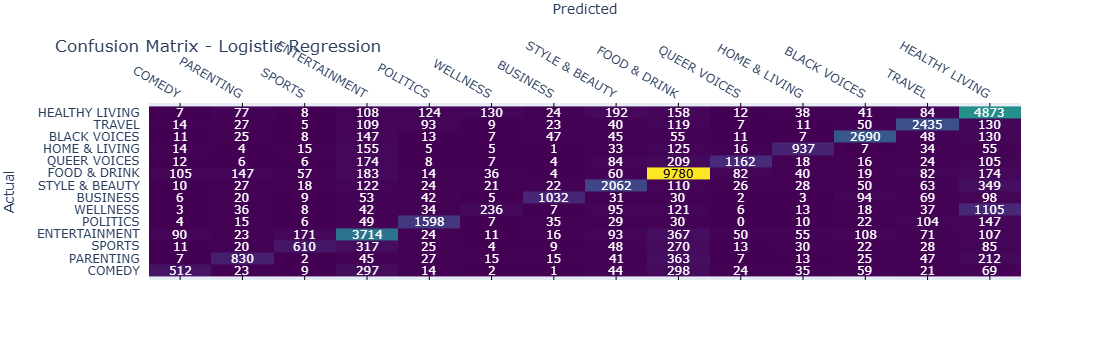

In [57]:

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Create a list of categories for the confusion matrix
categories = ['COMEDY', 'PARENTING', 'SPORTS', 'ENTERTAINMENT', 'POLITICS',
       'WELLNESS', 'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK',
       'QUEER VOICES', 'HOME & LIVING', 'BLACK VOICES', 'TRAVEL',
       'HEALTHY LIVING']

# Create the confusion matrix plot
fig = ff.create_annotated_heatmap(conf_matrix_lr, x=categories, y=categories, colorscale='Viridis')

# Update the layout to add title and axis labels
fig.update_layout(title='Confusion Matrix - Logistic Regression',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')

fig.show()


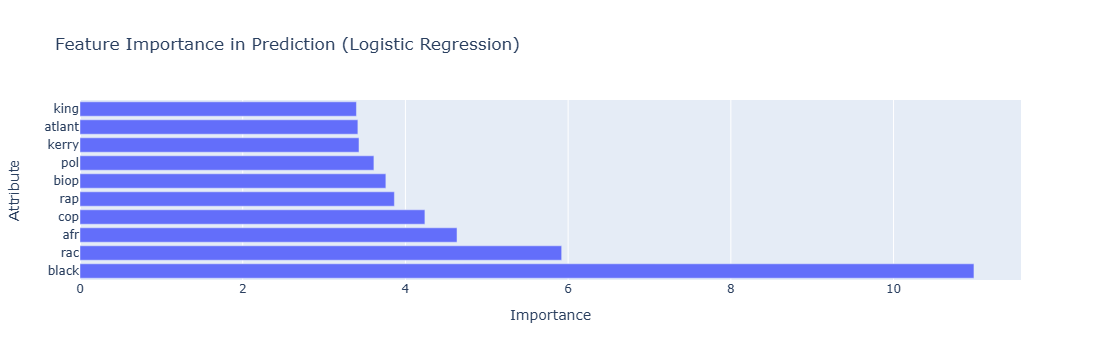

In [58]:

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lr.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

# Create a DataFrame from the top 10 features
top_features_lr = importances[:10]

# Create the bar chart
fig = px.bar(top_features_lr, x='Importance', y='Attribute', orientation='h', 
             title='Feature Importance in Prediction (Logistic Regression)',
             labels={'Importance':'Importance', 'Attribute':'Attribute'})

fig.show()


In [ ]:
#Import the DTC from the Sklearn 
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=1000)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

In [ ]:
# Calculate accuracy score
accuracy_dt = accuracy_score(y_test, y_pred)

# Generate classification report
report_dt = classification_report(y_test, y_pred)
print(f'Accuracy on validation set{accuracy_dt}')
print('________________________________________')
print('Classification report')

print(report_dt)

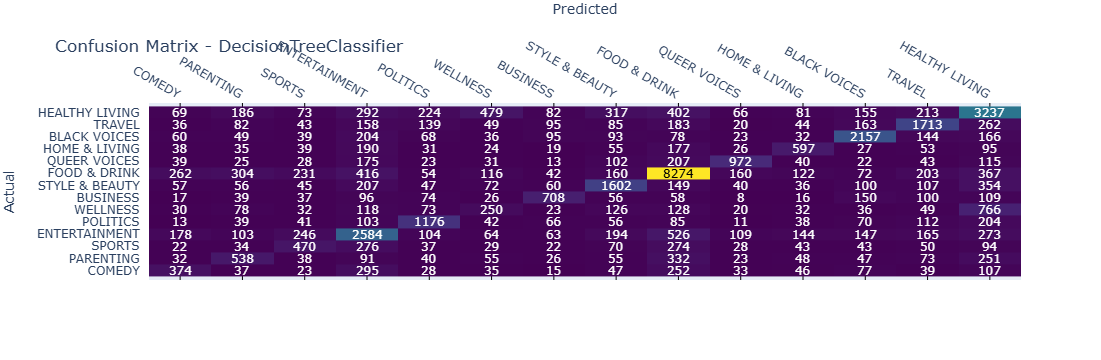

In [61]:

conf_matrix_dt = confusion_matrix(y_test, y_pred)

# Create a list of categories for the confusion matrix
categories = ['COMEDY', 'PARENTING', 'SPORTS', 'ENTERTAINMENT', 'POLITICS',
       'WELLNESS', 'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK',
       'QUEER VOICES', 'HOME & LIVING', 'BLACK VOICES', 'TRAVEL',
       'HEALTHY LIVING']

# Create the confusion matrix plot
fig = ff.create_annotated_heatmap(conf_matrix_dt, x=categories, y=categories, colorscale='Viridis')

# Update the layout to add title and axis labels
fig.update_layout(title='Confusion Matrix - DecisionTreeClassifier',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')

fig.show()


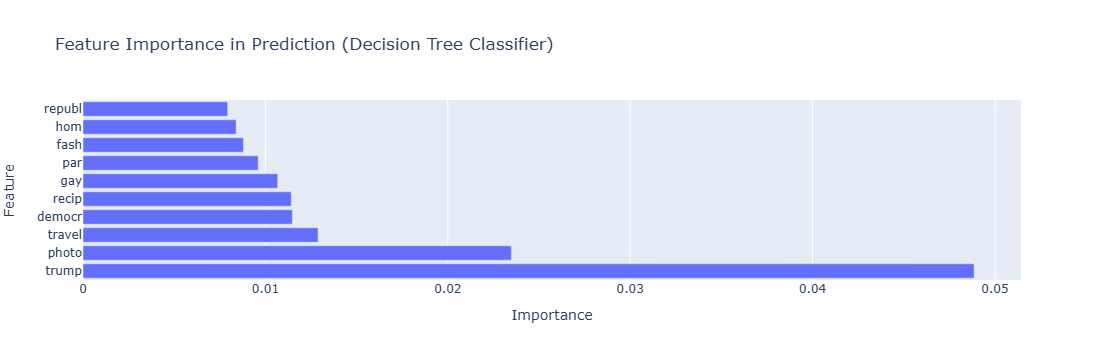

In [62]:

feature_scores = pd.Series(dtc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Create a DataFrame from the top 10 features
top_features = feature_scores[:10].reset_index()
top_features.columns = ['Feature', 'Importance']

# Create the bar chart
fig = px.bar(top_features, x='Importance', y='Feature', orientation='h', 
             title='Feature Importance in Prediction (Decision Tree Classifier)',
             labels={'Importance':'Importance', 'Feature':'Feature'})

fig.show()


In [63]:
#import the RFC from the Sklearn 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1000)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

In [64]:
# Calculate accuracy score
accuracy_rf = accuracy_score(y_test, y_pred_rfc)

# Generate classification report
report_lr = classification_report(y_test, y_pred_rfc)
print(f'Accuracy on validation set{accuracy_rf}')
print('________________________________________')
print('Classification report')

print(report_lr)

Accuracy on validation set0.676847043818894
________________________________________
Classification report
                precision    recall  f1-score   support

  BLACK VOICES       0.65      0.25      0.36      1408
      BUSINESS       0.60      0.35      0.44      1649
        COMEDY       0.63      0.31      0.41      1492
 ENTERTAINMENT       0.61      0.65      0.63      4900
  FOOD & DRINK       0.69      0.70      0.69      2056
HEALTHY LIVING       0.72      0.06      0.11      1761
 HOME & LIVING       0.77      0.57      0.66      1494
     PARENTING       0.63      0.70      0.66      2932
      POLITICS       0.75      0.90      0.82     10783
  QUEER VOICES       0.87      0.57      0.69      1835
        SPORTS       0.68      0.52      0.59      1406
STYLE & BEAUTY       0.72      0.80      0.76      3244
        TRAVEL       0.72      0.65      0.68      3072
      WELLNESS       0.56      0.79      0.66      5876

      accuracy                           0.68     4

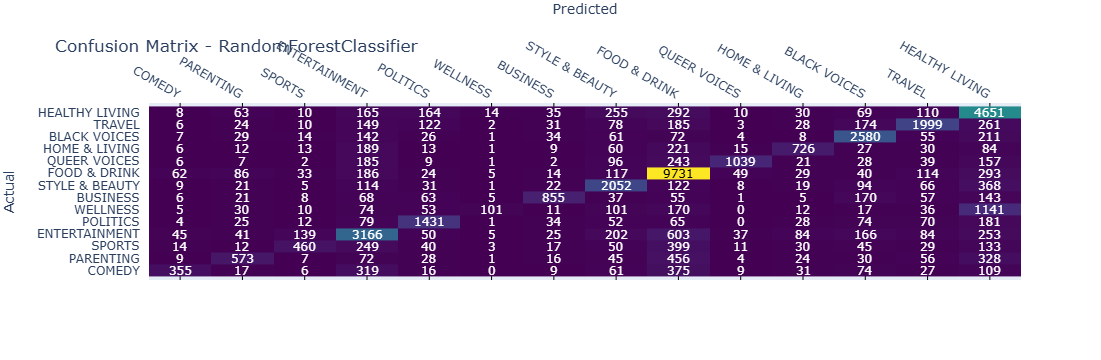

In [65]:

conf_matrix_rf= confusion_matrix(y_test, y_pred_rfc)

# Create a list of categories for the confusion matrix
categories = ['COMEDY', 'PARENTING', 'SPORTS', 'ENTERTAINMENT', 'POLITICS',
       'WELLNESS', 'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK',
       'QUEER VOICES', 'HOME & LIVING', 'BLACK VOICES', 'TRAVEL',
       'HEALTHY LIVING']

# Create the confusion matrix plot
fig = ff.create_annotated_heatmap(conf_matrix_rf, x=categories, y=categories, colorscale='Viridis')

# Update the layout to add title and axis labels
fig.update_layout(title='Confusion Matrix - RandomForestClassifier',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')

fig.show()


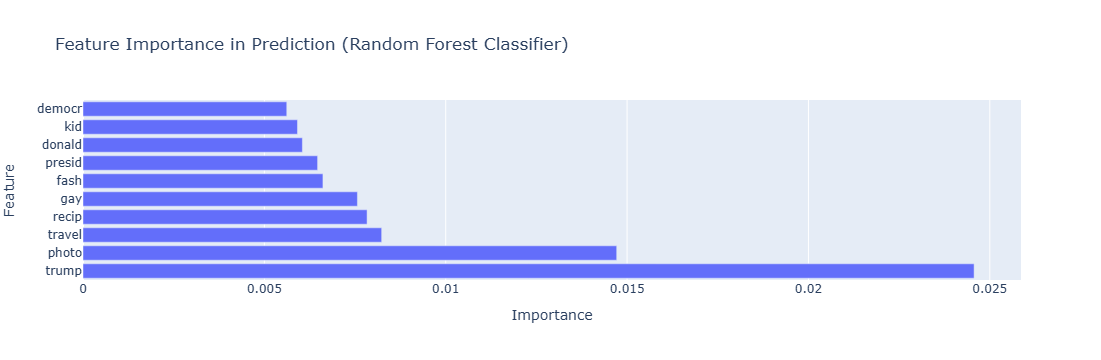

In [66]:

feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Create a DataFrame from the top 10 features
top_features = feature_scores[:10].reset_index()
top_features.columns = ['Feature', 'Importance']

# Create the bar chart
fig = px.bar(top_features, x='Importance', y='Feature', orientation='h', 
             title='Feature Importance in Prediction (Random Forest Classifier)',
             labels={'Importance':'Importance', 'Feature':'Feature'})

fig.show()


In [69]:
# Save the model to a file
#joblib.dump(lr, 'lr_tweet_category.joblib')
# Save the vectorizer to a file
#joblib.dump(vectorizer2, 'tfidf_tweet_category.joblib')


['tfidf_tweet_category.joblib']